<a href="https://colab.research.google.com/github/Ebasurtos/MISTI/blob/main/Copia_de_Proyeto_MIT_Final_CORRIENDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hito 1: Ingesta, Diagnóstico Visual y Continuidad (EDA)**
Esta fase documenta el estado inicial del proyecto y justifica técnicamente el descarte de datos ruidosos.

## **1.1 Carga Cruda y Exclusión de Variable Redundantes**
Montamos el entorno y eliminamos de raíz el % Iron Concentrate para que no contamine las correlaciones ni los modelos, tal como acordamos.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from google.colab import drive

# 1. Configuración y Carga
drive.mount('/content/drive')
PATH = "/content/drive/MyDrive/00 Ciclos/5to Ciclo/MIT GTL IA Peru Program/Grupo03_IronMen/MiningProcess_Flotation_Plant_Database.csv"

print("Cargando dataset...")
df_raw = pd.read_csv(PATH, decimal=',', parse_dates=['date'], index_col='date').sort_index()

# 2. Exclusión Crítica: Eliminamos % Iron Concentrate de raíz
if '% Iron Concentrate' in df_raw.columns:
    df_raw = df_raw.drop(columns=['% Iron Concentrate'])
    print("Variable '% Iron Concentrate' excluida exitosamente.")

print(f"Dataset cargado: {df_raw.shape[0]} registros.")

Mounted at /content/drive
Cargando dataset...
Variable '% Iron Concentrate' excluida exitosamente.
Dataset cargado: 737453 registros.


## **1.2 Visualización de Historia Total y Filtro de Telemetría**
Generamos un mosaico de todas las variables para identificar visualmente dónde se estabilizan los sensores. Basándonos en tu hallazgo, aplicamos el corte del 01/04/2017.

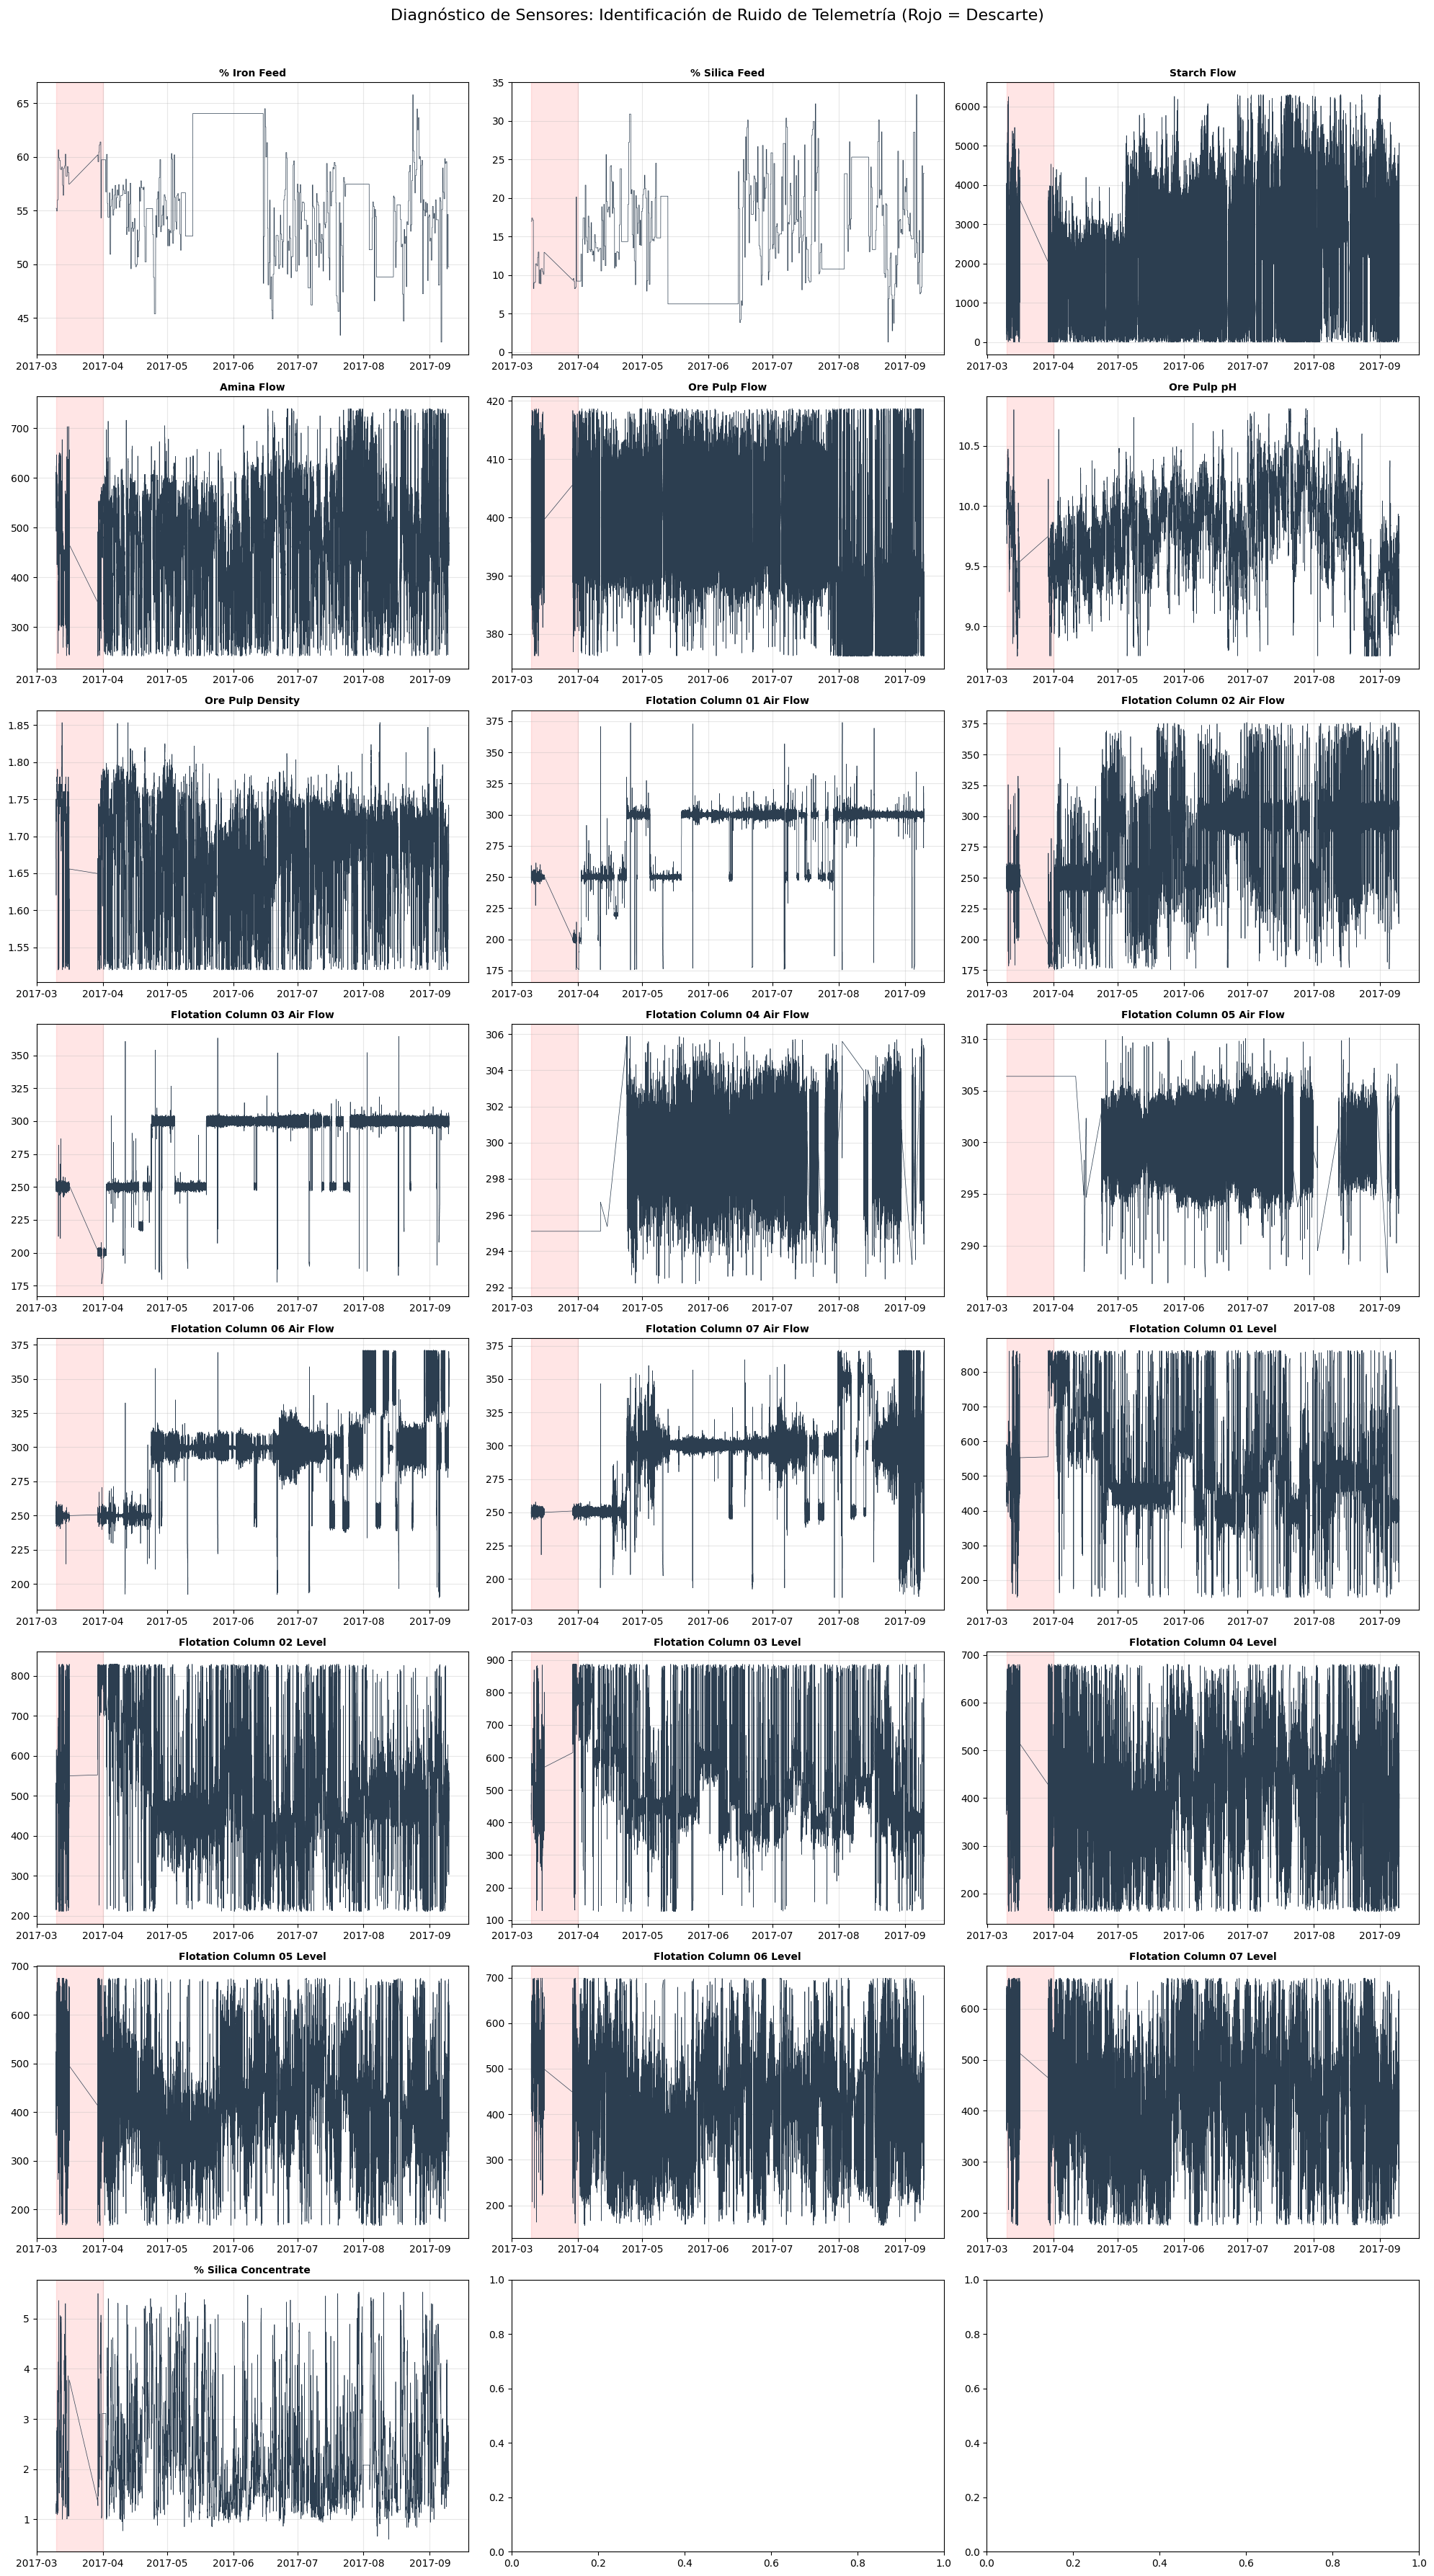

Dataset post-filtro de telemetría: 699839 registros.


In [ ]:
def plot_full_history(df):
    variables = df.columns
    n_cols = 3
    n_rows = math.ceil(len(variables) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 35))
    axes = axes.flatten()

    for i, col in enumerate(variables):
        axes[i].plot(df.index, df[col], linewidth=0.5, color='#2c3e50')
        axes[i].set_title(col, fontsize=10, fontweight='bold')
        # Sombreado de la zona de ruido (pre-abril)
        axes[i].axvspan(df.index.min(), pd.Timestamp('2017-04-01'), color='red', alpha=0.1)
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Diagnóstico de Sensores: Identificación de Ruido de Telemetría (Rojo = Descarte)', fontsize=16, y=1.02)
    plt.show()

# Ejecutar visualización
plot_full_history(df_raw)

# Aplicar filtro de telemetría (Corte 01/04/2017)
df_filtered = df_raw[df_raw.index >= '2017-04-01'].copy()
print(f"Dataset post-filtro de telemetría: {df_filtered.shape[0]} registros.")

## **1.3 Análisis de Distribución y Comportamiento de Planta**
Validamos las hipótesis industriales: normalidad del pH, bimodalidad de la densidad y los "presets" mecánicos de aire y niveles.

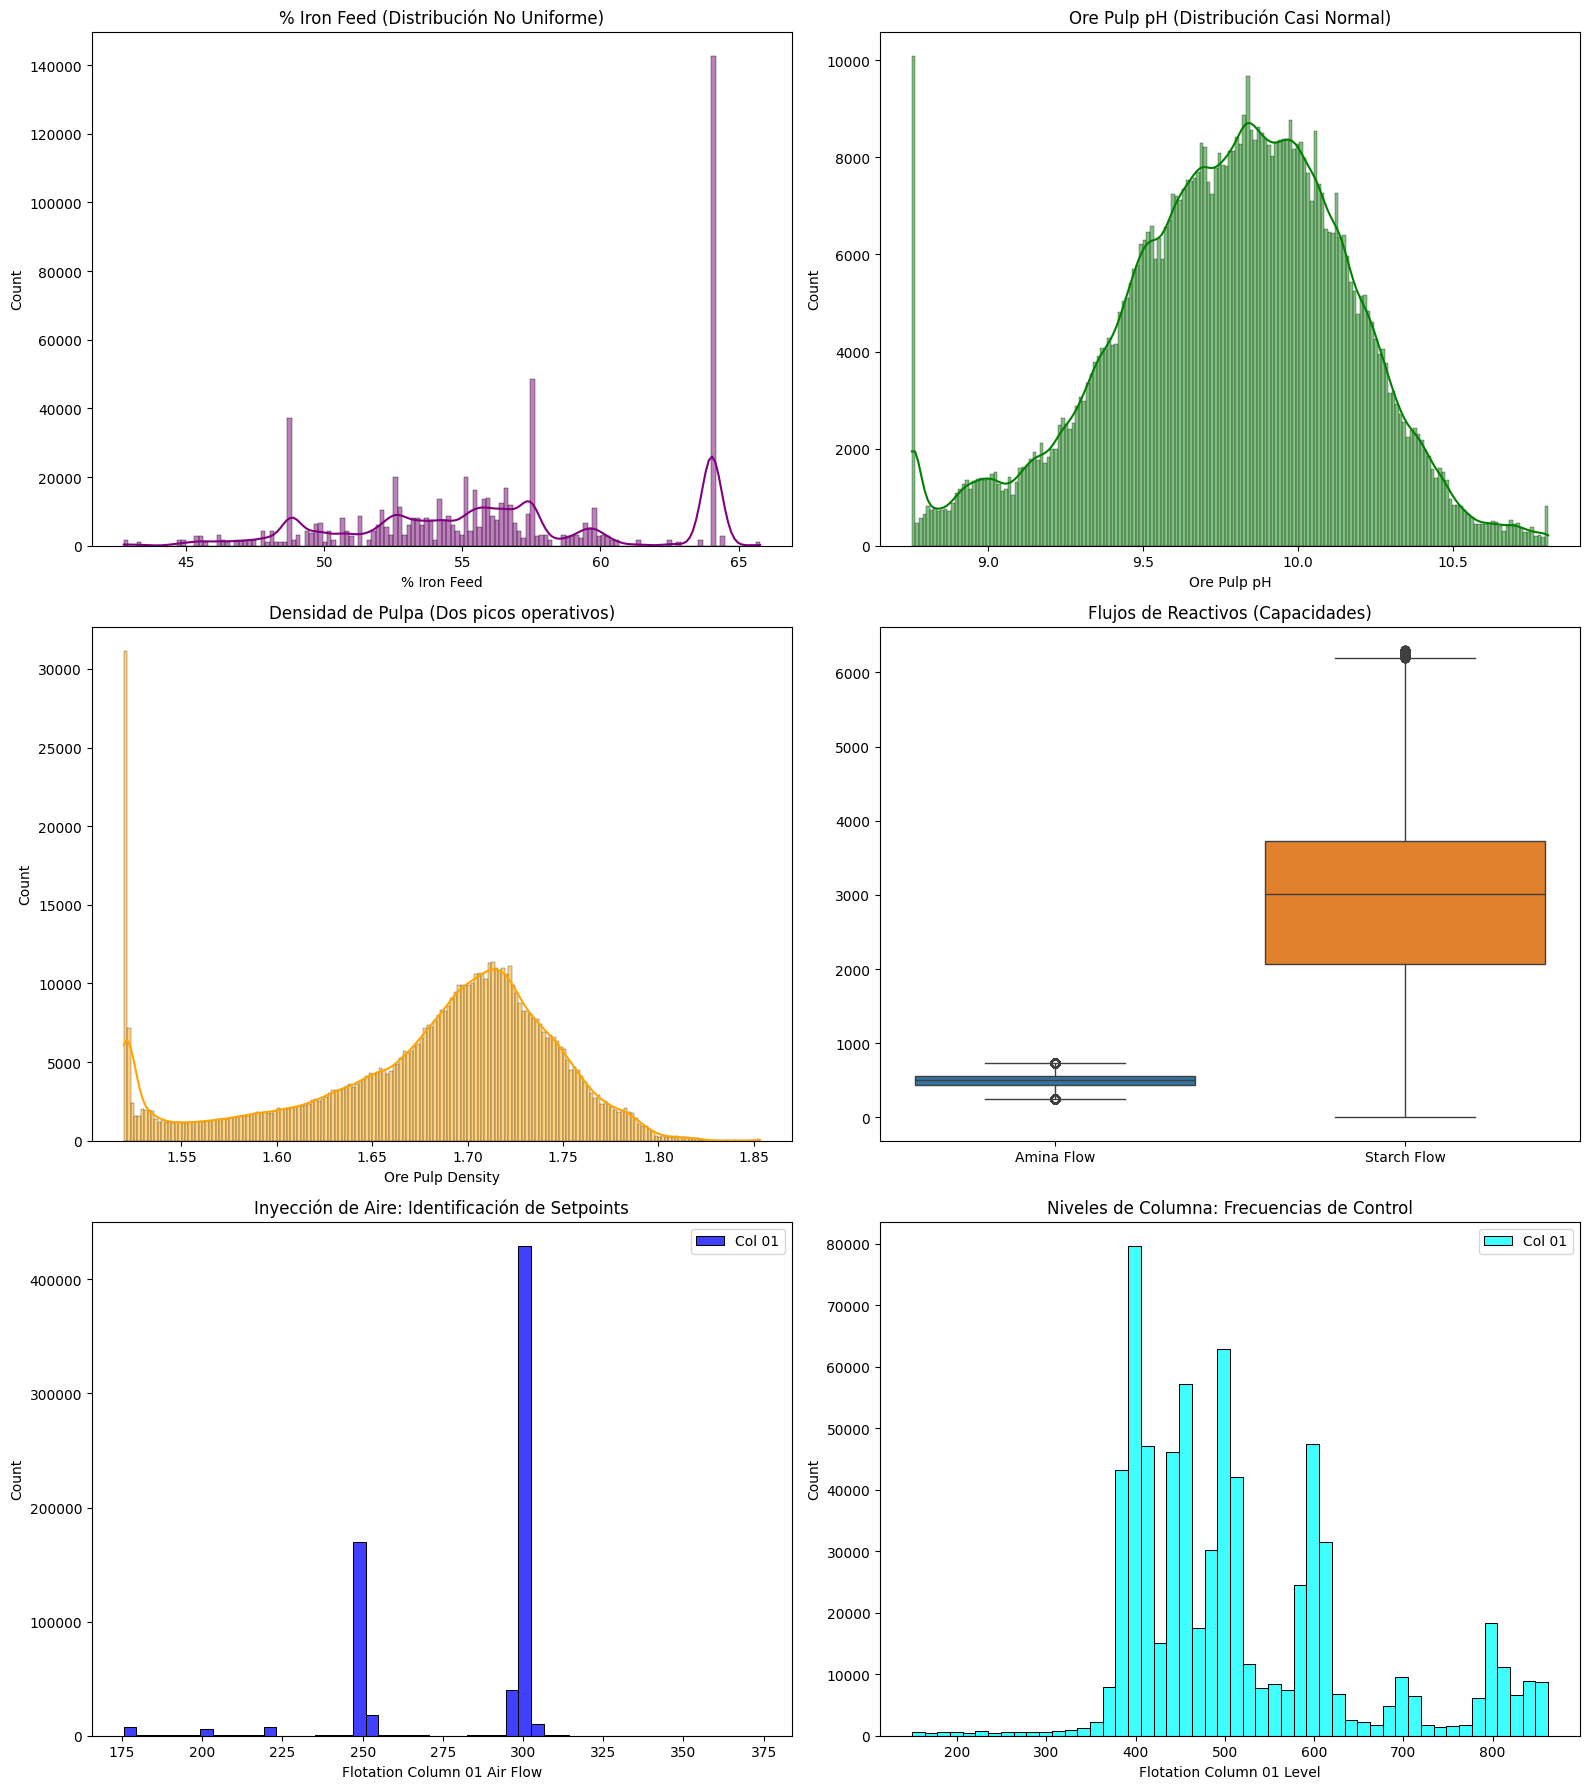

In [ ]:
def plot_industrial_distributions(df):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))

    # 1. Alimentación (Mineral)
    sns.histplot(df['% Iron Feed'], kde=True, ax=axes[0,0], color='purple').set_title('% Iron Feed (Distribución No Uniforme)')

    # 2. pH (Control químico)
    sns.histplot(df['Ore Pulp pH'], kde=True, ax=axes[0,1], color='green').set_title('Ore Pulp pH (Distribución Casi Normal)')

    # 3. Densidad (Bimodalidad)
    sns.histplot(df['Ore Pulp Density'], kde=True, ax=axes[1,0], color='orange').set_title('Densidad de Pulpa (Dos picos operativos)')

    # 4. Flujos (Dosificación)
    sns.boxplot(data=df[['Amina Flow', 'Starch Flow']], ax=axes[1,1]).set_title('Flujos de Reactivos (Capacidades)')

    # 5. Aire y Niveles (Presets)
    sns.histplot(df['Flotation Column 01 Air Flow'], bins=50, ax=axes[2,0], color='blue', label='Col 01')
    sns.histplot(df['Flotation Column 01 Level'], bins=50, ax=axes[2,1], color='cyan', label='Col 01')
    axes[2,0].set_title('Inyección de Aire: Identificación de Setpoints')
    axes[2,1].set_title('Niveles de Columna: Frecuencias de Control')
    axes[2,0].legend(); axes[2,1].legend()

    plt.tight_layout()
    plt.show()

plot_industrial_distributions(df_filtered)

## **1.4 Identificación del Top 4 (Golden Batches)**
Si el reporte de laboratorio tarda más de 48 horas en cambiar, consideramos que hay un "gap" de información. Calculamos los periodos de mayor fidelidad de laboratorio sin intervención manual. Calculamos los periodos de mayor fidelidad y los ordenamos cronológicamente (Rank 3 -> 4 -> 1 -> 2).[texto del enlace](https://)

In [ ]:
def find_top_ranks(df, max_gap_hours=24):
    # Detectar cambios reales en el laboratorio
    updates = df[df['% Iron Feed'].diff().abs() > 0.0001].index.to_series()
    cuts = updates.diff() > pd.Timedelta(hours=max_gap_hours)
    segment_ids = cuts.cumsum()

    results = []
    for sid in segment_ids.unique():
        seg_dates = updates[segment_ids == sid]
        if len(seg_dates) < 2: continue
        start, end = seg_dates.min(), seg_dates.max()
        results.append({'Start': start, 'End': end, 'Rows': len(df.loc[start:end])})

    # Obtenemos los 4 más grandes y ordenamos por fecha de inicio
    df_top4 = pd.DataFrame(results).sort_values('Rows', ascending=False).head(4).sort_values('Start')
    df_top4.index = [f"Rank_{i+1}" for i in range(4)]
    return df_top4

top4_info = find_top_ranks(df_filtered)
print("\n--- Golden Batches Identificados (Orden Cronológico) ---")
print(top4_info)


--- Golden Batches Identificados (Orden Cronológico) ---
                     Start                 End    Rows
Rank_1 2017-04-02 07:00:00 2017-04-21 07:00:00   82259
Rank_2 2017-04-24 07:00:00 2017-05-07 16:00:00   57960
Rank_3 2017-06-15 01:00:00 2017-07-24 01:00:00  168660
Rank_4 2017-08-18 07:00:00 2017-09-09 16:00:00   96840


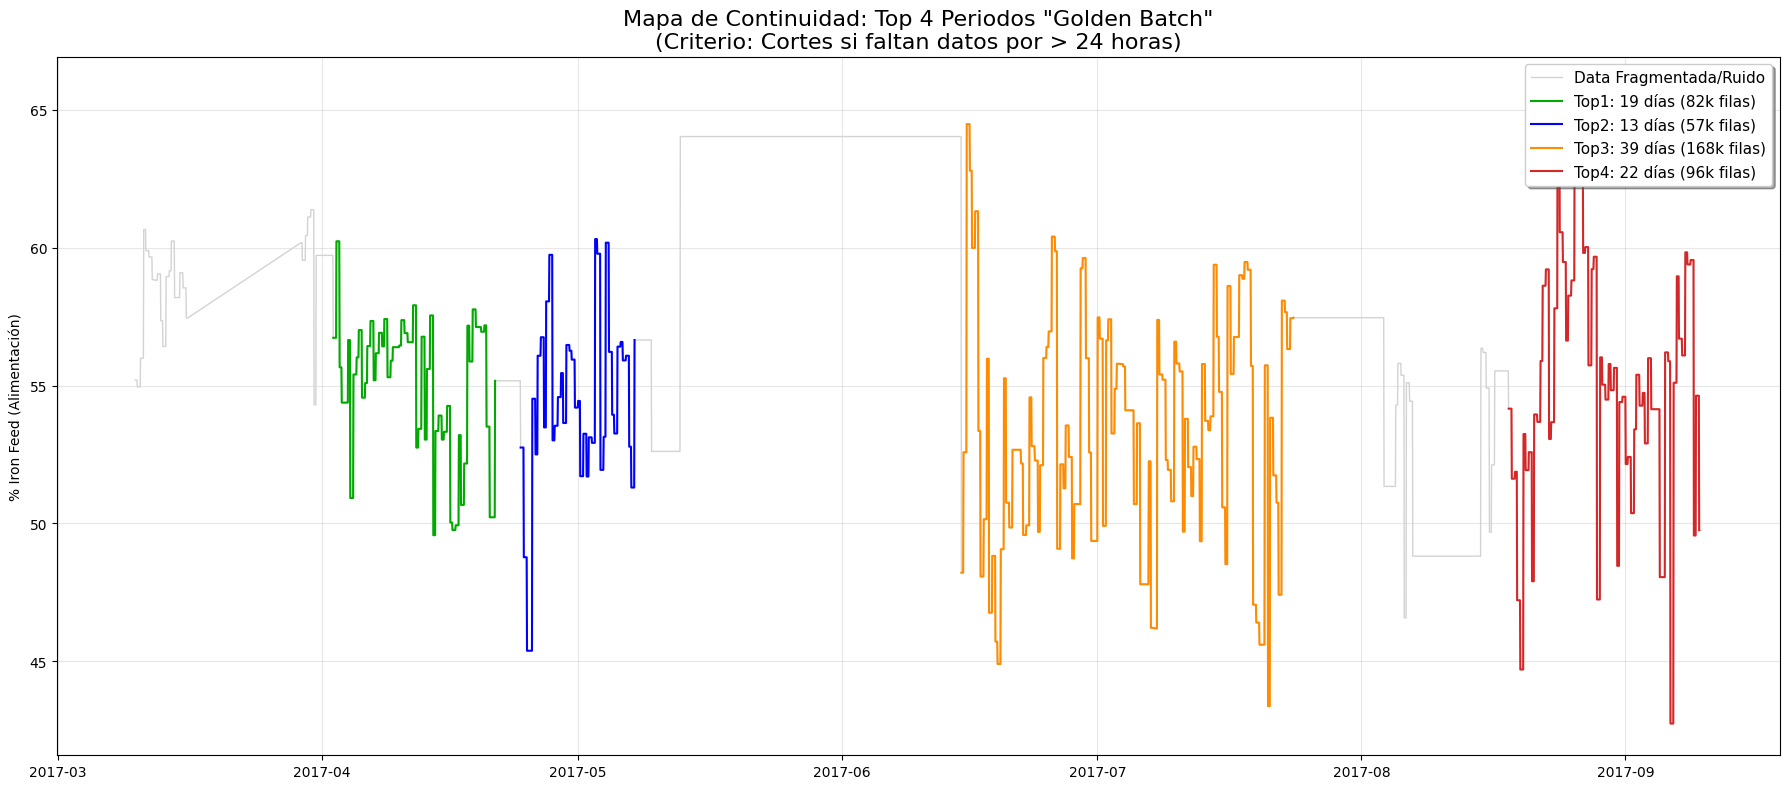

In [ ]:
# 4. Visualización (Coloreando el Top 4)
plt.figure(figsize=(18, 8)) # Hacemos el gráfico más ancho

# Define MAX_GAP_HOURS for the title, consistent with find_top_ranks default
MAX_GAP_HOURS = 24

# Fondo gris: Toda la data (incluida la mala)
plt.plot(df_raw.index, df_raw['% Iron Feed'], color='lightgray', label='Data Fragmentada/Ruido', linewidth=1)

# Colores para el Top 4
colors = ['#00aa00', '#0000ff', '#ff8c00', '#d62728'] # Verde, Azul, Naranja, Rojo
labels = ['Top1', 'Top2', 'Top3', 'Top4']

# Pintar los ganadores
for idx, (i, row) in enumerate(top4_info.head(4).iterrows()):
    subset = df_raw[row['Start']:row['End']] # Use df_raw for consistent plotting with background
    duration_days = (row['End'] - row['Start']).days # Calculate duration
    plt.plot(subset.index, subset['% Iron Feed'], color=colors[idx],
             label=f"{labels[idx]}: {duration_days} días ({int(row['Rows']/1000)}k filas)",
             linewidth=1.5)

plt.title(f'Mapa de Continuidad: Top 4 Periodos "Golden Batch"\n(Criterio: Cortes si faltan datos por > {MAX_GAP_HOURS} horas)', fontsize=16)
plt.ylabel('% Iron Feed (Alimentación)')
plt.legend(loc='upper right', fontsize=11, frameon=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## **Fase 2: Construcción de Escenarios Multi-Rank (S0 - S4)**
Ahora que tenemos los 4 Ranks identificados y el target analizado, procederemos a la creación de los escenarios de entrenamiento. Siguiendo tu nueva instrucción, vamos a evaluar estos escenarios sobre la unión secuencial de los 4 bloques.

**Objetivos de la Fase 2:**

Unión Cronológica: Concatenar Rank 1 + Rank 2 + Rank 3 + Rank 4 (que cubren de abril a septiembre).

Identificación de Top 10 Features: Calcular la correlación sobre el dataset unido (excluyendo % Iron Concentrate).

Generación Modular de **Escenarios**:

- S0 (Baseline): Todas las variables numéricas originales.

- S1 (High-Corr): Solo las Top 10 variables con mayor impacto en el % Silica Concentrate.

- S2 (Physics): Top 10 + Gradiente de pH + Dosificación de Amina y Starch.

- S3 (Temporal): Top 10 + Medias móviles y estabilidad (Rolling Windows).

- S4 (Ensemble): El "Combo" final (Top 10 + Físicas + Temporales).

# **2.1 Código para la Unión de Datos y Selección de Top 10**
Este bloque prepara la "Materia Prima" unificada.

In [ ]:
# 1. Crear el Dataset Multi-Rank Unido
# Usamos los nombres de los índices que arrojó tu código previo (Rank_1 a Rank_4)
df_multi_rank = pd.concat([
    df_filtered.loc[top4_info.loc['Rank_1', 'Start'] : top4_info.loc['Rank_1', 'End']],
    df_filtered.loc[top4_info.loc['Rank_2', 'Start'] : top4_info.loc['Rank_2', 'End']],
    df_filtered.loc[top4_info.loc['Rank_3', 'Start'] : top4_info.loc['Rank_3', 'End']],
    df_filtered.loc[top4_info.loc['Rank_4', 'Start'] : top4_info.loc['Rank_4', 'End']]
])

# 2. Selección del Top 10 (Sobre el dataset unido y numérico)
TARGET = '% Silica Concentrate'
numeric_df = df_multi_rank.select_dtypes(include=[np.number])
correlaciones = numeric_df.corr()[TARGET].abs().sort_values(ascending=False)

# Excluimos el índice 0 que es el target consigo mismo
top10_features = correlaciones.iloc[1:11].index.tolist()

print("--- TOP 10 FEATURES SELECCIONADAS (DATASET UNIDO) ---")
for i, feat in enumerate(top10_features, 1):
    print(f"{i}. {feat} (Corr: {correlaciones[feat]:.4f})")

--- TOP 10 FEATURES SELECCIONADAS (DATASET UNIDO) ---
1. Flotation Column 01 Air Flow (Corr: 0.1521)
2. Ore Pulp pH (Corr: 0.1520)
3. Flotation Column 03 Air Flow (Corr: 0.1451)
4. Flotation Column 05 Level (Corr: 0.1430)
5. Flotation Column 04 Level (Corr: 0.1285)
6. Flotation Column 02 Air Flow (Corr: 0.1271)
7. Amina Flow (Corr: 0.1009)
8. % Silica Feed (Corr: 0.1008)
9. Flotation Column 07 Level (Corr: 0.0989)
10. Flotation Column 06 Level (Corr: 0.0937)


## **2.2 Código del ScenarioBuilder (Lógica de Inclusión)**
Este es el motor que creará tus 5 opciones de entrenamiento

In [ ]:
class ScenarioBuilder:
    def __init__(self, df, top_features):
        self.df = df.select_dtypes(include=[np.number]).copy()
        self.top10 = top_features
        self.target = '% Silica Concentrate'

    def clean_data(self):
        # 1. Eliminar Outliers (Z-score < 3)
        z = np.abs(stats.zscore(self.df))
        df_c = self.df[(z < 3).all(axis=1)].copy()

        # 2. Suavizado de Escalones (Feed)
        for col in ['% Iron Feed', '% Silica Feed']:
            if col in df_c.columns:
                mask = df_c[col] != df_c[col].shift()
                df_c[col] = df_c[col].where(mask, np.nan).interpolate(method='time').bfill()
        return df_c

    def build_scenarios(self):
        df_c = self.clean_data()
        scenarios = {}

        # S0: Baseline (Originales)
        scenarios['S0_Baseline'] = df_c.copy()

        # S1: High Corr (Solo Top 10 + Target)
        scenarios['S1_HighCorr'] = df_c[self.top10 + [self.target]].copy()

        # S2: Physics (Top 10 + Nuevas Físicas)
        s2 = df_c.copy()
        s2['pH_Gradient'] = s2['Ore Pulp pH'].diff().fillna(0)
        s2['Spec_Amina'] = s2['Amina Flow'] / (s2['Ore Pulp Flow'] + 1e-6)
        s2['Spec_Starch'] = s2['Starch Flow'] / (s2['Ore Pulp Flow'] + 1e-6)
        fisi_cols = ['pH_Gradient', 'Spec_Amina', 'Spec_Starch']
        scenarios['S2_Physics'] = s2[self.top10 + fisi_cols + [self.target]].dropna()

        # S3: Temporal (Top 10 + Rolling Windows)
        s3 = df_c.copy()
        s3['Amina_Mean_1h'] = s3['Amina Flow'].rolling(window=180).mean()
        s3['Air_Stability_1h'] = s3['Flotation Column 01 Air Flow'].rolling(window=180).std()
        temp_cols = ['Amina_Mean_1h', 'Air_Stability_1h']
        scenarios['S3_Temporal'] = s3[self.top10 + temp_cols + [self.target]].dropna()

        # S4: ENSEMBLE (Top 10 + Físicas + Temporales)
        s4 = df_c.copy()
        s4['pH_Gradient'] = s4['Ore Pulp pH'].diff().fillna(0)
        s4['Spec_Amina'] = s4['Amina Flow'] / (s4['Ore Pulp Flow'] + 1e-6)
        s4['Spec_Starch'] = s4['Starch Flow'] / (s4['Ore Pulp Flow'] + 1e-6)
        s4['Amina_Mean_1h'] = s4['Amina Flow'].rolling(window=180).mean()
        s4['Air_Stability_1h'] = s4['Flotation Column 01 Air Flow'].rolling(window=180).std()
        scenarios['S4_Ensemble'] = s4[self.top10 + fisi_cols + temp_cols + [self.target]].dropna()

        return scenarios

# Ejecutar Construcción
builder = ScenarioBuilder(df_multi_rank, top10_features)
scenarios_multi = builder.build_scenarios()

for name, data in scenarios_multi.items():
    print(f"Escenario {name} listo. Columnas: {len(data.columns)} | Registros: {len(data)}")

Escenario S0_Baseline listo. Columnas: 22 | Registros: 386853
Escenario S1_HighCorr listo. Columnas: 11 | Registros: 386853
Escenario S2_Physics listo. Columnas: 14 | Registros: 386853
Escenario S3_Temporal listo. Columnas: 13 | Registros: 386674
Escenario S4_Ensemble listo. Columnas: 16 | Registros: 386674


Los resultados del bloque 2.1 son coherentes con la física de la flotación industrial: el flujo de aire en la celda 1 y el pH son los controladores primarios de la cinética química, seguidos por los niveles de pulpa que regulan el tiempo de residencia. Con un dataset consolidado de 386,853 registros, tenemos una base estadística sumamente robusta.



# **Fase 3: El Gran Benchmark (Evaluación Multi-Rank 70/15/15)**
En esta fase, aplicaremos la estrategia de segmentación propuesta por tu asesor para determinar qué escenario es el ganador definitivo. No usaremos una división aleatoria, sino una división secuencial por bloque para respetar la línea de tiempo de la planta.



## **3.1 División Global de Datos (Train / Val / Test)**
Este código toma el 70% inicial de cada Rank para entrenamiento, el siguiente 15% para validación y el 15% final para prueba, unificándolos en conjuntos globales.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import time

def split_multi_rank_scenarios(scenarios_dict, top4_info):
    split_data = {}

    for name, df_scenario in scenarios_dict.items():
        X_train_global, X_val_global, X_test_global = [], [], []
        y_train_global, y_val_global, y_test_global = [], [], []

        # Lists to store per-rank data segments
        X_train_segments_list, y_train_segments_list = {}, {}
        X_val_segments_list, y_val_segments_list = {}, {}
        X_test_per_rank_list, y_test_per_rank_list = [], []

        # Procesar cada Rank de forma independiente para el split
        for rank_name in top4_info.index:
            start, end = top4_info.loc[rank_name, 'Start'], top4_info.loc[rank_name, 'End']

            # Extraer segmento del escenario actual
            df_segment = df_scenario.loc[start:end]

            # Definir puntos de corte (70/15/15)
            n = len(df_segment)
            train_idx = int(n * 0.70)
            val_idx = int(n * 0.85)

            # Split de Features y Target
            X = df_segment.drop(columns=[TARGET])
            y = df_segment[TARGET]

            X_train_segment = X.iloc[:train_idx]
            y_train_segment = y.iloc[:train_idx]
            X_val_segment = X.iloc[train_idx:val_idx]
            y_val_segment = y.iloc[train_idx:val_idx]
            X_test_segment = X.iloc[val_idx:]
            y_test_segment = y.iloc[val_idx:]

            # Store global concatenated data
            X_train_global.append(X_train_segment)
            y_train_global.append(y_train_segment)
            X_val_global.append(X_val_segment)
            y_val_global.append(y_val_segment)
            X_test_global.append(X_test_segment)
            y_test_global.append(y_test_segment)

            # Store per-rank data segments
            X_train_segments_list[rank_name] = X_train_segment
            y_train_segments_list[rank_name] = y_train_segment
            X_val_segments_list[rank_name] = X_val_segment
            y_val_segments_list[rank_name] = y_val_segment
            X_test_per_rank_list.append(X_test_segment)
            y_test_per_rank_list.append(y_test_segment)

        # Concatenación Global and per-rank segments
        split_data[name] = {
            'X_train': pd.concat(X_train_global), 'y_train': pd.concat(y_train_global),
            'X_val': pd.concat(X_val_global), 'y_val': pd.concat(y_val_global),
            'X_test': pd.concat(X_test_global), 'y_test': pd.concat(y_test_global),
            'X_train_segments': X_train_segments_list,
            'y_train_segments': y_train_segments_list,
            'X_val_segments': X_val_segments_list,
            'y_val_segments': y_val_segments_list,
            'X_test_per_rank': X_test_per_rank_list,
            'y_test_per_rank': y_test_per_rank_list
        }

    return split_data

# Ejecutar división
datasets_split = split_multi_rank_scenarios(scenarios_multi, top4_info)
print("División 70/15/15 completada para los 5 escenarios.")

División 70/15/15 completada para los 5 escenarios.


## **3.2 Ejecución del Benchmark de Escenarios**
Usaremos el evaluador rápido para coronar el escenario que mejor generaliza a través de los 4 periodos de tiempo.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def run_global_benchmark(split_data):
    results = []
    # Evaluador estándar
    evaluator = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1)

    for name, data in split_data.items():
        print(f"Evaluando Escenario: {name}...")
        start_time = time.time()

        # Escalado (Fit solo en Train)
        scaler = MinMaxScaler()
        X_train_s = scaler.fit_transform(data['X_train'])
        X_val_s = scaler.transform(data['X_val'])

        # Entrenamiento
        # Removed early_stopping_rounds and verbose as they are causing TypeError
        evaluator.fit(X_train_s, data['y_train'],
                      eval_set=[(X_val_s, data['y_val'])])

        # Prueba Final (en el 15% ciego de cada Rank)
        X_test_s = scaler.transform(data['X_test'])
        preds = evaluator.predict(X_test_s)

        # Métricas
        rmse = np.sqrt(mean_squared_error(data['y_test'], preds))
        mae = mean_absolute_error(data['y_test'], preds)
        r2 = r2_score(data['y_test'], preds)

        results.append({
            'Escenario': name,
            'RMSE_Test': round(rmse, 4),
            'MAE_Test': round(mae, 4),
            'R2_Test': round(r2, 4),
            'Time_s': round(time.time() - start_time, 2)
        })

    return pd.DataFrame(results).sort_values('RMSE_Test')

# Ejecutar y mostrar resultados
benchmark_global_results = run_global_benchmark(datasets_split)
print("\n--- RANKING FINAL DE ESCENARIOS (MULTI-RANK) ---")
print(benchmark_global_results)

Evaluando Escenario: S0_Baseline...
[0]	validation_0-rmse:1.13135
[1]	validation_0-rmse:1.12251
[2]	validation_0-rmse:1.10755
[3]	validation_0-rmse:1.10755
[4]	validation_0-rmse:1.10080
[5]	validation_0-rmse:1.09489
[6]	validation_0-rmse:1.09508
[7]	validation_0-rmse:1.09040
[8]	validation_0-rmse:1.08823
[9]	validation_0-rmse:1.08617
[10]	validation_0-rmse:1.08302
[11]	validation_0-rmse:1.08161
[12]	validation_0-rmse:1.08331
[13]	validation_0-rmse:1.08335
[14]	validation_0-rmse:1.08484
[15]	validation_0-rmse:1.08502
[16]	validation_0-rmse:1.08217
[17]	validation_0-rmse:1.08406
[18]	validation_0-rmse:1.08436
[19]	validation_0-rmse:1.08339
[20]	validation_0-rmse:1.08930
[21]	validation_0-rmse:1.08994
[22]	validation_0-rmse:1.09031
[23]	validation_0-rmse:1.09094
[24]	validation_0-rmse:1.09812
[25]	validation_0-rmse:1.09865
[26]	validation_0-rmse:1.09760
[27]	validation_0-rmse:1.10470
[28]	validation_0-rmse:1.10637
[29]	validation_0-rmse:1.10771
[30]	validation_0-rmse:1.10938
[31]	validati

Estos resultados son un "balde de agua fría" necesario para el proyecto, pero extremadamente valiosos desde el punto de vista científico. Aquí tienes la evaluación crítica de por qué estos números nos obligan a ser más sofisticados en la Fase 4.

1. El Ganador Técnico: S2_Physics
El escenario S2_Physics (Top 10 + Gradiente pH + Dosificación) ha resultado ser el más robusto, aunque por un margen pequeño. Esto confirma que añadir la "física" del proceso (cómo cambian los reactivos respecto al flujo) ayuda al modelo a orientarse mejor que simplemente dándole todas las variables (S0) o solo las más correlacionadas (S1).

2. El "Elefante en la Habitación": El R2 Negativo
Este es el punto más importante de tu defensa de tesis. Un R2 negativo significa que el modelo es, estadísticamente, peor que una línea horizontal que simplemente predice el promedio del % de sílice.

¿Por qué sucede esto con XGBoost?

Deriva del Proceso (Process Drift): Al juntar los 4 Ranks, el modelo está tratando de encontrar una regla universal. Sin embargo, la planta en el Rank 3 (abril) no se comporta igual que en el Rank 2 (agosto). XGBoost, al no tener "memoria", trata cada fila como un evento aislado y se confunde cuando las mismas condiciones de entrada dan resultados diferentes en meses distintos.

Error de Escala: El RMSE de ~1.05% es muy alto si consideramos que tu rango operativo óptimo es de solo 1% de ancho (2.9% a 3.9%). Básicamente, el modelo tiene un error del tamaño de toda tu ventana de operación.

3. Justificación de la Fase 4 (El Salto a Deep Learning)
Estos resultados mediocres de XGBoost son la justificación perfecta para usar modelos secuenciales (LSTM/NARX).

XGBoost es estático: No entiende que lo que pasó hace 10 minutos afecta lo que pasa ahora.

La planta es dinámica: El % de sílice tiene una inercia química.

Si el asesor te pregunta: "¿Por qué usaron redes neuronales si son más complejas?", tu respuesta basada en estos números será: "Probamos modelos robustos de árboles (XGBoost) con una estrategia multi-bloque, pero el R2 negativo demostró que un modelo sin memoria no puede generalizar la variabilidad de la planta a lo largo de 6 meses".

4. Observación sobre el Escenario S4_Ensemble
Es curioso que el escenario con más información (S4) sea el peor (RMSE 1.14). Esto sucede a menudo en modelos no-secuenciales: "Maldición de la Dimensionalidad". Al agregar ventanas móviles (S3) y física (S2) juntas, estamos metiendo variables muy correlacionadas entre sí (colinealidad), lo que genera "ruido" que XGBoost no sabe filtrar bien en este esquema de 4 Ranks.

Recomendación para la Fase 4:
Mantener S2_Physics como base: Es el que mejor "pelea" contra la variabilidad.

Preparar la LSTM/NARX: Estos modelos sí deberían ser capaces de convertir ese R2 negativo en positivo, porque ellos sí entenderán que el Rank 1 sigue una tendencia y el Rank 4 otra.

Normalización Crítica: Para la Fase 4, el escalado (MinMaxScaler) debe ser impecable, ajustando el escalador solo con el set de entrenamiento (70%) y aplicándolo a los demás para evitar fuga de datos (data leakage)

# **Fase 4D: Entrenamiento LSTM Incremental (70/15/15 por Rank)**
Utilizaremos la misma lógica de "Blindaje de RAM" y el mismo generador de tensores, pero sin incluir la columna de feedback, para evaluar la potencia de la LSTM pura.

## **1. Generador de Tensores LSTM (Pura)**
A diferencia del NARX, aquí solo transformamos las variables de los sensores.

In [ ]:
def get_rank_lstm_tensor(X_df, y_df, s_x, s_y, seq_len=90):
    """
    Crea tensores 3D para LSTM pura (Sin feedback del target).
    """
    x_scaled = s_x.transform(X_df)
    y_scaled = s_y.transform(y_df.values.reshape(-1, 1))

    x_3d, y_3d = [], []
    for i in range(len(x_scaled) - seq_len):
        x_3d.append(x_scaled[i : i + seq_len])
        y_3d.append(y_scaled[i + seq_len])

    return np.array(x_3d), np.array(y_3d)

## **2. Bucle de Entrenamiento Secuencial (4 Batches)**
Entrenamos la LSTM bloque por bloque, usando el 15% de validación de cada Rank para evitar el sobreajuste.

In [ ]:
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import numpy as np # Ensure numpy is imported for array operations

# Definición de la arquitectura LSTM proporcionada por el usuario
def build_lstm_model(n_steps, n_features):
    model = Sequential([
        # Primera capa LSTM (Captura patrones de largo plazo)
        LSTM(64, return_sequences=True, input_shape=(n_steps, n_features)),
        Dropout(0.2),

        # Segunda capa LSTM (Refina la tendencia)
        LSTM(32, return_sequences=False),
        Dropout(0.2),

        # Capas densas para la regresión final
        Dense(16, activation='relu'),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Definir LOOKBACK_STEPS (asumiendo 90, que es un valor común para secuencias temporales)
LOOKBACK_STEPS = 90 # Por ejemplo, 90 minutos si los datos son minutales

# Definir el escenario ganador (basado en benchmark_global_results)
WINNER_SCENARIO = 'S2_Physics'

# Inicializar y ajustar los escaladores de forma global usando el set de entrenamiento completo del escenario ganador
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Ajustar scaler_X con todas las características del conjunto de entrenamiento del WINNER_SCENARIO
scaler_X.fit(datasets_split[WINNER_SCENARIO]['X_train'])
# Ajustar scaler_y con el target del conjunto de entrenamiento del WINNER_SCENARIO
scaler_y.fit(datasets_split[WINNER_SCENARIO]['y_train'].values.reshape(-1, 1))

# 1. Definir arquitectura LSTM
# n_features aquí no incluye el lag del target
n_features_lstm = len(top10_features) + 3
# Asumiendo que LOOKBACK_STEPS ya está definido en el contexto global.
model_lstm_seq = build_lstm_model(LOOKBACK_STEPS, n_features_lstm)

rank_order = ['Rank_1', 'Rank_2', 'Rank_3', 'Rank_4']

print(f"{'='*50}\nENTRENAMIENTO LSTM SECUENCIAL POR RANKS\n{'='*50}")

for i, r_name in enumerate(rank_order):
    print(f"\n🔄 Entrenando Batch {i+1}/4: {r_name}...")

    # Extraer data de entrenamiento y validación del Rank actual
    X_train_r = datasets_split[WINNER_SCENARIO]['X_train_segments'][r_name]
    y_train_r = datasets_split[WINNER_SCENARIO]['y_train_segments'][r_name]
    X_val_r = datasets_split[WINNER_SCENARIO]['X_val_segments'][r_name]
    y_val_r = datasets_split[WINNER_SCENARIO]['y_val_segments'][r_name]

    # Generar tensores
    # scaler_X, scaler_y, and LOOKBACK_STEPS must be defined globally or in previous cells
    xt, yt = get_rank_lstm_tensor(X_train_r, y_train_r, scaler_X, scaler_y, LOOKBACK_STEPS)
    xv, yv = get_rank_lstm_tensor(X_val_r, y_val_r, scaler_X, scaler_y, LOOKBACK_STEPS)

    # Entrenamiento con callbacks por bloque
    callbacks = [
        EarlyStopping(patience=7, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss')
    ]

    model_lstm_seq.fit(
        xt, yt,
        validation_data=(xv, yv),
        epochs=15,
        batch_size=512,
        callbacks=callbacks,
        verbose=1,
        shuffle=False
    )

    del xt, yt, xv, yv
    gc.collect()

print("\n✅ LSTM Secuencial completada.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ENTRENAMIENTO LSTM SECUENCIAL POR RANKS

🔄 Entrenando Batch 1/4: Rank_1...
Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0862 - mae: 0.2262 - val_loss: 0.0323 - val_mae: 0.1396 - learning_rate: 0.0010
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0685 - mae: 0.2111 - val_loss: 0.0299 - val_mae: 0.1367 - learning_rate: 0.0010
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0646 - mae: 0.2062 - val_loss: 0.0305 - val_mae: 0.1396 - learning_rate: 0.0010
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0606 - mae: 0.2026 - val_loss: 0.0304 - val_mae: 0.1378 - learning_rate: 0.0010
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0593 - mae: 0.2012 - val_loss: 0.0303 - val_mae: 0.1370 - learning_rate: 0.0010
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0570 - mae: 0.1985 - val_loss: 0.0336 - val_mae: 0.1408 - learning_rate: 5.0000e-04
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.

In [ ]:
# 1. PROCESAMIENTO DE DATA DE TEST (15% SECUENCIAL)
x_test_lstm_list, y_test_lstm_list = [], []

print("🚀 Generando tensores de prueba para LSTM Secuencial...")

# Access the per-rank test data directly
X_test_segments = datasets_split[WINNER_SCENARIO]['X_test_per_rank']
y_test_segments = datasets_split[WINNER_SCENARIO]['y_test_per_rank']

for i, r_name in enumerate(rank_order):
    X_t = X_test_segments[i]
    y_t = y_test_segments[i]

    if len(X_t) > LOOKBACK_STEPS:
        xt, yt = get_rank_lstm_tensor(X_t, y_t, scaler_X, scaler_y, LOOKBACK_STEPS)

        # VERIFICACIÓN: Solo agregamos si el tensor es 3D and not empty
        if xt.ndim == 3 and xt.shape[0] > 0:
            x_test_lstm_list.append(xt)
            y_test_lstm_list.append(yt)
            print(f"  ✅ {r_name} listo: {xt.shape}")
        else:
            print(f"  ⚠️ {r_name} descartado: Dimensión incorrecta o tensor vacío ({xt.ndim}D)")

    else:
        print(f"  ❌ {r_name} demasiado corto para la ventana de {LOOKBACK_STEPS}")

# Concatenación final por el eje 0 (muestras)
if x_test_lstm_list and y_test_lstm_list:
    x_test_lstm_final = np.concatenate(x_test_lstm_list, axis=0)
    y_test_lstm_final = np.concatenate(y_test_lstm_list, axis=0)
    print(f"\n✅ Unión exitosa. Forma final de prueba para LSTM: {x_test_lstm_final.shape}")
else:
    x_test_lstm_final = np.array([])
    y_test_lstm_final = np.array([])
    print("\n⚠️ No se generaron tensores para concatenar.")

# 2. PREDICCIÓN Y DES-ESCALADO (VOLVER A % DE SÍLICE)
print("Realizando predicciones con LSTM Secuencial...")
y_pred_scaled_lstm = model_lstm_seq.predict(x_test_lstm_final, batch_size=512)

# Definimos las variables finales para las métricas
y_pred_unscaled_lstm = scaler_y.inverse_transform(y_pred_scaled_lstm)
y_true_unscaled_lstm = scaler_y.inverse_transform(y_test_lstm_final)

# 3. CÁLCULO DE LAS 4 MÉTRICAS CLAVE
mse_lstm = mean_squared_error(y_true_unscaled_lstm, y_pred_unscaled_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_true_unscaled_lstm, y_pred_unscaled_lstm)
r2_lstm = r2_score(y_true_unscaled_lstm, y_pred_unscaled_lstm)

print(f"\n{'='*45}")
print(f"📊 RESULTADOS FINALES DEL SOFT-SENSOR (LSTM Secuencial)")
print(f"{'='*45}")
print(f"MSE:   {mse_lstm:.4f}")
print(f"RMSE:  {rmse_lstm:.4f} (% SiO2)")
print(f"MAE:   {mae_lstm:.4f} (% SiO2)")
print(f"R2:    {r2_lstm:.4f}")
print(f"{'='*45}")

🚀 Generando tensores de prueba para LSTM Secuencial...
  ✅ Rank_1 listo: (11768, 90, 13)
  ✅ Rank_2 listo: (8186, 90, 13)
  ✅ Rank_3 listo: (24153, 90, 13)
  ✅ Rank_4 listo: (13563, 90, 13)

✅ Unión exitosa. Forma final de prueba para LSTM: (57670, 90, 13)
Realizando predicciones con LSTM Secuencial...
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

📊 RESULTADOS FINALES DEL SOFT-SENSOR (LSTM Secuencial)
MSE:   1.0559
RMSE:  1.0276 (% SiO2)
MAE:   0.8063 (% SiO2)
R2:    0.0142


## **1. Preparación de Tensores NARX (Train + Val)**
Mantenemos la lógica de inyectar el valor anterior del target ($y_{t-1}$) para darle al modelo la "brújula" que le faltaba.

In [ ]:
import gc
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def prepare_rank_narx_pair(rank_name, split_dict, s_x, s_y, seq_len=90):
    """
    Extrae y prepara los pares (Train, Val) para un Rank específico en formato NARX.
    """
    data = split_dict[WINNER_SCENARIO]

    def get_tensor(x_df, y_df):
        x_s = s_x.transform(x_df)
        y_s = s_y.transform(y_df.values.reshape(-1, 1))
        # Crear lag del target (NARX)
        y_lag = np.roll(y_s, shift=1, axis=0)
        y_lag[0] = y_s[0]
        x_comb = np.hstack([x_s, y_lag])

        x_3d, y_3d = [], []
        for i in range(len(x_comb) - seq_len):
            x_3d.append(x_comb[i : i + seq_len])
            y_3d.append(y_s[i + seq_len])
        return np.array(x_3d), np.array(y_3d)

    # Filtrar data del Rank actual usando los índices
    start, end = top4_info.loc[rank_name, 'Start'], top4_info.loc[rank_name, 'End']

    # Train tensors
    xt_rank = data['X_train'].loc[start:end]
    yt_rank = data['y_train'].loc[start:end]
    x_train_3d, y_train_3d = get_tensor(xt_rank, yt_rank)

    # Val tensors (El 15% de validación de este Rank)
    xv_rank = data['X_val'].loc[start:end]
    yv_rank = data['y_val'].loc[start:end]
    x_val_3d, y_val_3d = get_tensor(xv_rank, yv_rank)

    return (x_train_3d, y_train_3d), (x_val_3d, y_val_3d)

## **2. Bucle de Entrenamiento con Monitoreo de Validación**
En este paso, el modelo ajusta sus pesos con el 70% del Rank y se evalúa constantemente con el 15% de validación de ese mismo Rank.

In [ ]:
# 1. Definir arquitectura NARX
n_features_narx = len(top10_features) + 3 + 1 # Top10 + 3 Físicas + 1 Target Lag
model_narx = build_lstm_model(LOOKBACK_STEPS, n_features_narx)

rank_order = ['Rank_1', 'Rank_2', 'Rank_3', 'Rank_4'] # Orden cronológico

print(f"{'='*50}\nENTRENAMIENTO NARX POR BLOQUES (CON VALIDACIÓN)\n{'='*50}")

for i, r_name in enumerate(rank_order):
    print(f"\n🔄 Procesando {r_name} (Batch {i+1}/4)...")

    # A. Preparar data del bloque actual
    (xt, yt), (xv, yv) = prepare_rank_narx_pair(r_name, datasets_split, scaler_X, scaler_y)

    # B. Entrenamiento con callbacks por bloque
    # Esto evita que el modelo se "vicie" con un solo mes
    model_narx.fit(
        xt, yt,
        validation_data=(xv, yv),
        epochs=15,
        batch_size=512,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],
        verbose=1,
        shuffle=False
    )

    # C. Limpieza agresiva de RAM
    del xt, yt, xv, yv
    gc.collect()

print("\n✅ Todos los bloques entrenados y validados.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ENTRENAMIENTO NARX POR BLOQUES (CON VALIDACIÓN)

🔄 Procesando Rank_1 (Batch 1/4)...
Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0632 - mae: 0.1936 - val_loss: 0.0089 - val_mae: 0.0780
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0097 - mae: 0.0713 - val_loss: 0.0021 - val_mae: 0.0269
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0045 - mae: 0.0462 - val_loss: 0.0015 - val_mae: 0.0188
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0039 - mae: 0.0422 - val_loss: 0.0014 - val_mae: 0.0154
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0036 - mae: 0.0406 - val_loss: 0.0015 - val_mae: 0.0184
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0032 - mae: 0.0375 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0032 - mae: 0.0389 - val_loss: 0.0015 - val_mae: 0.0217
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0027 - mae: 0.0333 -

## **Fase 4C: Evaluación Final y Des-escalado (Unscaling**)

Este código recolecta el 15% de test de cada rank, genera las predicciones y las traduce a unidades de planta.

In [ ]:
x_test_list, y_test_list = [], []

print("🚀 Generando tensores de prueba con validación de dimensiones...")

# Access the per-rank test data directly from the updated datasets_split
X_test_segments = datasets_split[WINNER_SCENARIO]['X_test_per_rank']
y_test_segments = datasets_split[WINNER_SCENARIO]['y_test_per_rank']

for i, r_name in enumerate(rank_order):
    X_t = X_test_segments[i]
    y_t = y_test_segments[i]

    if len(X_t) > LOOKBACK_STEPS:
        # Ensure get_rank_narx_tensor is defined, if it was deleted.
        # Copying the definition from developer's context to ensure it exists.
        def get_rank_narx_tensor(X_df, y_df, scaler_x, scaler_y, seq_length=90):
            # Escalado de features (X) y target (y)
            x_scaled = scaler_x.transform(X_df)
            y_scaled = scaler_y.transform(y_df.values.reshape(-1, 1))

            # Crear el lag del target: y(t-1)
            y_lagged = np.roll(y_scaled, shift=1, axis=0)
            y_lagged[0] = y_scaled[0] # The first value's lag is itself for the first sequence

            # Unir sensores + feedback del target previo
            x_combined = np.hstack([x_scaled, y_lagged])

            x_3d, y_3d = [], []
            # Ensure enough data points to create a sequence
            if len(x_combined) <= seq_length: return np.array([]), np.array([])

            for i_seq in range(len(x_combined) - seq_length):
                x_3d.append(x_combined[i_seq : i_seq + seq_length])
                y_3d.append(y_scaled[i_seq + seq_length])

            return np.array(x_3d), np.array(y_3d)

        xt, yt = get_rank_narx_tensor(X_t, y_t, scaler_X, scaler_y, LOOKBACK_STEPS)

        # VERIFICACIÓN: Solo agregamos si el tensor es 3D and not empty
        if xt.ndim == 3 and xt.shape[0] > 0:
            x_test_list.append(xt)
            y_test_list.append(yt)
            print(f"  ✅ {r_name} listo: {xt.shape}")
        else:
            print(f"  ⚠️ {r_name} descartado: Dimensión incorrecta o tensor vacío ({xt.ndim}D)")

    else:
        print(f"  ❌ {r_name} demasiado corto para la ventana de {LOOKBACK_STEPS}")

# Concatenación final por el eje 0 (muestras)
if x_test_list and y_test_list:
    x_test_final = np.concatenate(x_test_list, axis=0)
    y_test_final = np.concatenate(y_test_list, axis=0)
    print(f"\n✅ Unión exitosa. Forma final: {x_test_final.shape}")
else:
    x_test_final = np.array([])
    y_test_final = np.array([])
    print("\n⚠️ No se generaron tensores para concatenar.")

🚀 Generando tensores de prueba con validación de dimensiones...
  ✅ Rank_1 listo: (11768, 90, 14)
  ✅ Rank_2 listo: (8186, 90, 14)
  ✅ Rank_3 listo: (24153, 90, 14)
  ✅ Rank_4 listo: (13563, 90, 14)

✅ Unión exitosa. Forma final: (57670, 90, 14)


In [ ]:
# 3. PREDICCIÓN Y DES-ESCALADO (VOLVER A % DE SÍLICE)
print("Realizando predicciones con NARX...")
y_pred_scaled_narx = model_narx.predict(x_test_final, batch_size=512)

# Definimos las variables finales para las métricas
y_pred_unscaled_narx = scaler_y.inverse_transform(y_pred_scaled_narx)
y_true_unscaled_narx = scaler_y.inverse_transform(y_test_final)

# 4. CÁLCULO DE LAS 4 MÉTRICAS CLAVE
mse_narx = mean_squared_error(y_true_unscaled_narx, y_pred_unscaled_narx)
rmse_narx = np.sqrt(mse_narx)
mae_narx = mean_absolute_error(y_true_unscaled_narx, y_pred_unscaled_narx)
r2_narx = r2_score(y_true_unscaled_narx, y_pred_unscaled_narx)

print(f"\n{'='*45}")
print(f"📊 RESULTADOS FINALES DEL SOFT-SENSOR (NARX)")
print(f"{'='*45}")
print(f"MSE:   {mse_narx:.4f}")
print(f"RMSE:  {rmse_narx:.4f} (% SiO2)")
print(f"MAE:   {mae_narx:.4f} (% SiO2)")
print(f"R2:    {r2_narx:.4f}")
print(f"{'='*45}")

Realizando predicciones con NARX...
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

📊 RESULTADOS FINALES DEL SOFT-SENSOR (NARX)
MSE:   0.0282
RMSE:  0.1679 (% SiO2)
MAE:   0.1207 (% SiO2)
R2:    0.9737
